In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit 
from functions import *
import time
from itertools import product
import seaborn as sb

# Code for identifiability and generalizability in Inverse Reinforcement Learning from Multiple Experts

## Generate the environments for the Strebulaev Whited experiment

In [2]:
### Base parameters
theta      = 0.55
delta      = 0.2
r          = 0.05
rho        = 0.7
sigma_eps  = 0.04
m          = 3
n          = 20 ### Grid only depends on the number of shocks # |S| is n^2, |A| is n
n_step     = 100
n_traj     = 1000
discount   = 1/(1+r)
n_features = 3
temp = 1e-2

In [3]:
### Dynamics
### Transition matrix of shocks
policies = []
opt_policies = []
soft_values =  []
Ts = []
for rho in [0.7]: #,0.2,0.7]:
    for theta in [0.55]:#, 0.25, 0.65]:
        for sigma_eps in [0.02, 0.04, 0.6]:
            Tauchen = tauchen_86(n,m,rho,sigma_eps)
            Tz, zs = Tauchen['Tz'],np.exp(Tauchen['lzs'])
            ### Policy 
            opt_policy_f, _ = gen_opt(theta,delta,r,sigma_eps,rho)
            ks = opt_policy_f(zs)
            states = states_f(ks,zs)
            n_states = states.shape[0]
            n_actions = len(ks)
            T = transition_matrix_f(Tz,len(ks))
            transition_probability = T.transpose(1,0,2)
            ### Feature cube
            n_states, n_actions = len(states),len(ks)
            feat_cube = np.empty((n_states, n_actions, n_features))
            if n_features == 3:
              a_true = np.array([1,1,-1])
              for i,s in enumerate(states): # s = (k,z)
                for j, a in enumerate([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]): #for j,a in enumerate(ks):
                  #feat_cube[i,j,0] =  s[1]*s[0]**theta # output 
                  #feat_cube[i,j,1] =  (1-delta)*s[0] # (1-delta)*k
                  #feat_cube[i,j,2] =  a # k'   -0.5*a
                  #feat_cube[i,j,0] =  s[1]*s[0]**theta # output
                  #feat_cube[i,j,1] =  a-(1-delta)*s[0] # investment, a - (1-delta)*k
                  #feat_cube[i,j,2] =  a*s[0]
                  #feat_cube[i,j,0] =  s[1]*((1-delta)*s[0]+a)**theta               # Output: z*(k')^theta
                  #feat_cube[i,j,1] =  (1-delta)*s[0]                               # Capital stock this period: (1-delta)*k
                  #feat_cube[i,j,2] =  (1-delta)*s[0]+a
                  feat_cube[i,j,0] =  s[1]*((1-delta)*s[0]+a*s[0])**theta          # Output: z*(k')^theta
                  feat_cube[i,j,1] =  (1-delta)*s[0]                               # Capital stock this period: (1-delta)*k
                  feat_cube[i,j,2] =  a*s[0]
                  

            a_true = np.array([1,1,-1])
            reward = feat_cube.dot(a_true)
            soft_optimal_policy, soft_value = soft_value_iteration(n_states, n_actions, transition_probability, reward, discount,threshold=1e-5)

            policies.append(soft_optimal_policy)
            soft_values.append(soft_value)
            opt_policies.append(opt_policy_f)
            Ts.append(transition_probability)

# Random Matrices experiments

35
2.339161927902906 -2.083234501912948


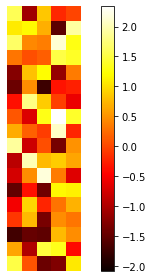

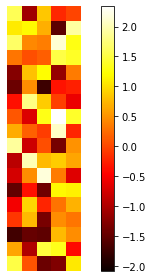

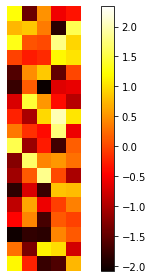

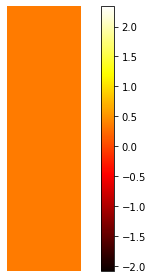

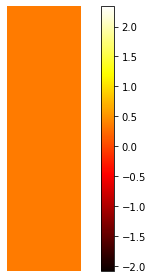

In [4]:
## Test with random matrices
for seed in range(1):
    n_s = 18
    n_a = 5
    np.random.seed(seed)
    T_1 = generate_random_transition(n_s, n_a)
    T_2 = generate_random_transition(n_s, n_a)
    identity = np.array([np.eye(n_s) for a in range(n_a)]).transpose(2,0,1).reshape(n_s*n_a, -1)
    A_1 = identity - discount*T_1
    A_2 = identity - discount*T_2
    A = np.hstack([A_1, -A_2])
    rank_random_A=np.linalg.matrix_rank(A)
    print(rank_random_A)
    rand_reward = generate_random_reward(n_s, n_a)
    soft_optimal_policy_1, _ = soft_value_iteration(n_s, n_a, T_1.reshape(n_s,n_a,n_s), rand_reward, discount,threshold=1e-5)
    #reward_2 = generate_random_reward(n_s, n_a)
    soft_optimal_policy_2, _ = soft_value_iteration(n_s, n_a, T_2.reshape(n_s,n_a,n_s), rand_reward, discount,threshold=1e-5)
    b = np.log(soft_optimal_policy_1.reshape(n_s*n_a, -1)) - np.log(soft_optimal_policy_2.reshape(n_s*n_a, -1))
    v = np.linalg.solve(A.T@A,A.T@b)
    v_1 = v[:n_s]
    v_2 = v[n_s:]
    reward_recovered_1 = np.log(soft_optimal_policy_1.reshape(n_s*n_a, -1)) - A_1@v_1
    reward_recovered_2 = np.log(soft_optimal_policy_2.reshape(n_s*n_a, -1)) - A_2@v_2
    limit_max= max(np.max(reward_recovered_1),np.max(reward_recovered_2),np.max(rand_reward))
    limit_min= min(np.min(reward_recovered_1),np.min(reward_recovered_2),np.min(rand_reward))
    print(limit_max, limit_min)
    plot_reward(reward_recovered_1.reshape(n_s, n_a),"figs/Random_Matrices_recovered_1",limit_max,limit_min)
    plot_reward(reward_recovered_2.reshape(n_s, n_a),"figs/Random_Matrices_recovered_2",limit_max,limit_min)
    plot_reward(rand_reward.reshape(n_s, n_a),"figs/Random_Matrices_true",limit_max,limit_min)
    plot_reward(reward_recovered_1.reshape(n_s, n_a)-rand_reward.reshape(n_s, n_a),"figs/Random_Matrices_difference_1",limit_max,limit_min)
    plot_reward(reward_recovered_2.reshape(n_s, n_a)-rand_reward.reshape(n_s, n_a),"figs/Random_Matrices_difference_2",limit_max,limit_min)

# Strebulaev Whited experiments

## Generalizability experiment

761
1161
761


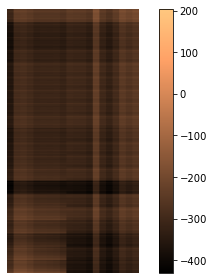

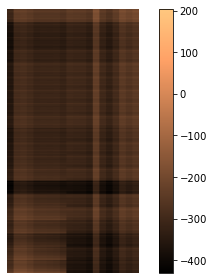

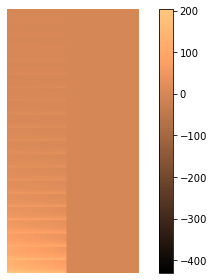

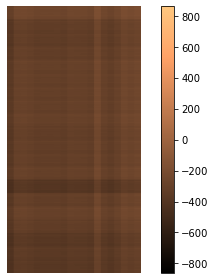

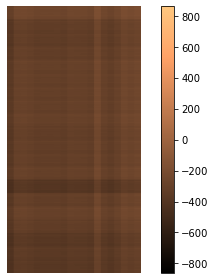

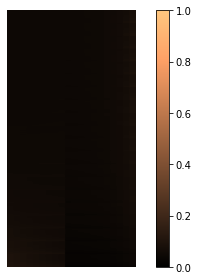

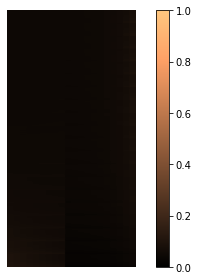

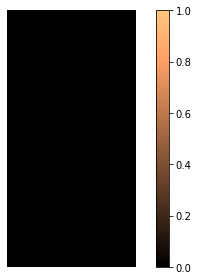

In [5]:
ranks = []
ranks_B = []
ids_1 = []
ids_2 = []
noise_1 = 0.00
noise_2 = 0.00
noise_3 = 0.00
for expert_1 in [1]:
    for expert_2 in [2]:
        for expert_3 in [0]:
            Ts_1 = (1-noise_1)*Ts[expert_1] + noise_1*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            Ts_2 = (1-noise_2)*Ts[expert_2] + noise_2*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            Ts_3 = (1-noise_3)*Ts[expert_3] + noise_3*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            identity = np.array([np.eye(n_states) for a in range(n)]).transpose(1,0,2)
            matrix_1 = (identity - discount*Ts_1).reshape(n_states*n_actions, -1) 
            matrix_2 = (identity - discount*Ts_2).reshape(n_states*n_actions, -1)
            matrix_3 = (identity - discount*Ts_3).reshape(n_states*n_actions, -1)
            zer = np.zeros_like(matrix_1)
            #print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
            matrix = np.hstack([matrix_1, - matrix_2])
            matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])
            ranks.append(np.linalg.matrix_rank(matrix))
            ranks_B.append(np.linalg.matrix_rank(matrix_B))
            print(ranks[-1])
            print(ranks_B[-1])
            print(ranks_B[-1] - n_states)
            ids_1.append(expert_1)
            ids_2.append(expert_2)
            soft_optimal_policy_1, _ = soft_value_iteration(n_states, n_actions, Ts_1, reward, discount,threshold=1e-5,temp=temp)
            #reward_2 = generate_random_reward(n_s, n_a)
            soft_optimal_policy_2, _ = soft_value_iteration(n_states, n_actions, Ts_2, reward, discount,threshold=1e-5,temp=temp)
            b = 1/temp*np.log(soft_optimal_policy_1.reshape(n_states*n_actions, -1)) - 1/temp*np.log(soft_optimal_policy_2.reshape(n_states*n_actions, -1))
            v = np.linalg.solve(matrix.T@matrix,matrix.T@b)
            v_1 = v[:n_states]
            v_2 = v[n_states:]
            reward_recovered_1 = 1/temp*np.log(soft_optimal_policy_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
            reward_recovered_2 = 1/temp*np.log(soft_optimal_policy_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
            
            limit_max= max(np.max(reward_recovered_1),np.max(reward_recovered_2),np.max(reward))
            limit_min= min(np.min(reward_recovered_1),np.min(reward_recovered_2),np.min(reward))
            limit_abs = max(-limit_min, limit_max)
            plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/Strebulaev_recovered_1",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1),"figs/Strebulaev_recovered_2",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/Strebulaev_true",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1) - np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/Strebulaev_difference_1",2*limit_abs,-2*limit_abs,color="copper")
            plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1) - np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/Strebulaev_difference_2",2*limit_abs,-2*limit_abs,color="copper")
            
            #RECOVERY TEST
            soft_optimal_policy_3, _ = soft_value_iteration(n_states, n_actions, Ts_3, reward, discount,threshold=1e-5,temp=temp)
            predicted_policy_3, _ = soft_value_iteration(n_states, n_actions, Ts_3, reward_recovered_2.reshape(n_states,n_actions), discount,threshold=1e-5,temp=temp)
            
            
            plot_reward(np.repeat(soft_optimal_policy_3,10,axis=1),"figs/Strebulaev_expert",1,0,color="copper")
            plot_reward(np.repeat(predicted_policy_3,10,axis=1),"figs/Strebulaev_recovered_expert",1,0,color="copper")
            plot_reward(np.repeat(soft_optimal_policy_3 - predicted_policy_3,10,axis=1),"figs/Strebulaev_difference_expert",1,0,color="copper")
    

## Identifiability with linear features

803 2|S| + d for identification


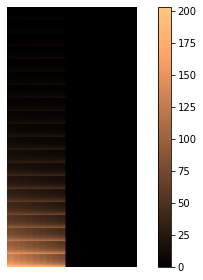

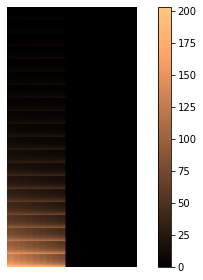

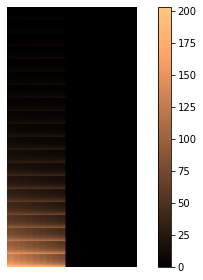

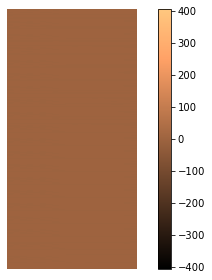

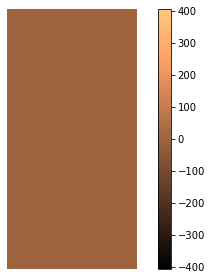

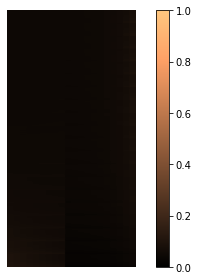

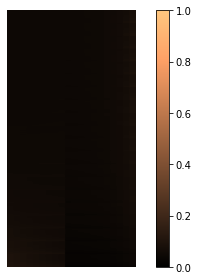

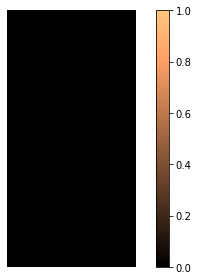

In [6]:
#Check rank with feature matrix
ranks = []
ranks_B = []
ranks_C = []
ids_1 = []
ids_2 = []
noise_1 = 0.00
noise_2 = 0.00
noise_3 = 0.00
for expert_1 in [1]:
    for expert_2 in [2]:
        for expert_3 in [0]:
            
            feat_matrix = feat_cube.reshape(n_states*n_actions, -1)
            
            Ts_1 = (1-noise_1)*Ts[expert_1] + noise_1*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            Ts_2 = (1-noise_2)*Ts[expert_2] + noise_2*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            Ts_3 = (1-noise_3)*Ts[expert_3] + noise_3*generate_random_transition(n**2, n).reshape(n**2,n,n**2)
            identity = np.array([np.eye(n_states) for a in range(n)]).transpose(1,0,2)
            
            matrix_1 = (identity - discount*Ts_1).reshape(n_states*n_actions, -1) 
            matrix_2 = (identity - discount*Ts_2).reshape(n_states*n_actions, -1)
            matrix_3 = (identity - discount*Ts_3).reshape(n_states*n_actions, -1)
            zer = np.zeros_like(matrix_1)
            zer2 = np.zeros_like(feat_matrix)
            #print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
            matrix = np.hstack([matrix_1, - matrix_2])
            matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])
            matrix_C = np.vstack([np.hstack([matrix_1, - matrix_2, zer2]), np.hstack([matrix_1, zer, feat_matrix])])
            ranks.append(np.linalg.matrix_rank(matrix))
            ranks_B.append(np.linalg.matrix_rank(matrix_B))
            ranks_C.append(np.linalg.matrix_rank(matrix_C))
            print(ranks_C[-1], "2|S| + d for identification")
            ids_1.append(expert_1)
            ids_2.append(expert_2)
            soft_optimal_policy_1, _ = soft_value_iteration(n_states, n_actions, Ts_1, reward, discount,threshold=1e-10,temp=temp)
            #reward_2 = generate_random_reward(n_s, n_a)
            soft_optimal_policy_2, _ = soft_value_iteration(n_states, n_actions, Ts_2, reward, discount,threshold=1e-10,temp=temp)
            b = 1/temp*np.log(soft_optimal_policy_1.reshape(n_states*n_actions, -1)) - 1/temp*np.log(soft_optimal_policy_2.reshape(n_states*n_actions, -1))
            b = np.vstack([b, 1/temp*np.log(soft_optimal_policy_1.reshape(n_states*n_actions, -1))])
            v = np.linalg.solve(matrix_C.T@matrix_C,matrix_C.T@b)
            v_1 = v[:n_states]
            v_2 = v[n_states:-feat_matrix.shape[1]]
            recovered_weights = v[-feat_matrix.shape[1]:]
            reward_recovered_1 = 1/temp*np.log(soft_optimal_policy_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
            reward_recovered_2 = 1/temp*np.log(soft_optimal_policy_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
            limit_max= max(np.max(reward_recovered_1),np.max(reward_recovered_2),np.max(reward))
            limit_min= min(np.min(reward_recovered_1),np.min(reward_recovered_2),np.min(reward))
            limit_abs = max(-limit_min, limit_max)
            plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/linStrebulaev_recovered_1",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1),"figs/linStrebulaev_recovered_2",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/linStrebulaev_true",limit_max,limit_min,color="copper")
            plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1) - np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/linStrebulaev_difference_1",2*limit_abs,-2*limit_abs,color="copper")
            plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1) - np.repeat(reward.reshape(n_states,n_actions),10,axis=1),"figs/linStrebulaev_difference_2",2*limit_abs,-2*limit_abs,color="copper")
            
            #RECOVERY TEST
            soft_optimal_policy_3, _ = soft_value_iteration(n_states, n_actions, Ts_3, reward, discount,threshold=1e-5,temp=temp)
            predicted_policy_3, _ = soft_value_iteration(n_states, n_actions, Ts_3, reward_recovered_2.reshape(n_states,n_actions), discount,threshold=1e-5,temp=temp)
            
            
            plot_reward(np.repeat(soft_optimal_policy_3,10,axis=1),"figs/linStrebulaev_expert",1,0,color="copper")
            plot_reward(np.repeat(predicted_policy_3,10,axis=1),"figs/linStrebulaev_recovered_expert",1,0,color="copper")
            plot_reward(np.repeat(soft_optimal_policy_3 - predicted_policy_3,10,axis=1),"figs/linStrebulaev_difference_expert",1,0,color="copper")
    

In [7]:
recovered_weights

array([[ 1.],
       [ 1.],
       [-1.]])

# GridWorlds experiments

In [ ]:
import sys
import copy
import matplotlib.pyplot as plt
sys.path.insert(0, 'src/')

from optimizers import *
from agent import Agent
from environment import *
from IRLalgorithms import IRLsolver
from MDPsolver import MDPsolver
np.random.seed(0)
mode =2
dim=10
noise_1 = 0.4
noise_2 = 0.2
noise_3 = 0.3
discount_1=0.9
discount_2=0.9
discount_3=0.9
gridworld_1 = GridWorldEnvironment(mode, dim,prop=noise_1, gamma=discount_1,action_penalty=True)
solver_1 = MDPsolver(gridworld_1)
gridworld_2 = GridWorldEnvironment(mode, dim,prop=noise_2, gamma=discount_2,action_penalty=True)
solver_2 = MDPsolver(gridworld_2)
gridworld_3 = GridWorldEnvironment(mode, dim,prop=noise_3, gamma=discount_3,action_penalty=True)
solver_3 = MDPsolver(gridworld_3)
n_actions=4
n_states=dim**2

expert_1 = solver_1.soft_value_iteration() 
expert_2 = solver_2.soft_value_iteration() 

T_1, T_2, T_3 = gridworld_1.T.transpose(1,0,2), gridworld_2.T.transpose(1,0,2), gridworld_3.T.transpose(1,0,2)

identity = np.array([np.eye(n_states) for a in range(n_actions)]).transpose(1,0,2)
matrix_1 = (identity - discount_1*T_1).reshape(n_states*n_actions, -1) 
matrix_2 = (identity - discount_2*T_2).reshape(n_states*n_actions, -1)
matrix_3 = (identity - discount_3*T_3).reshape(n_states*n_actions, -1)

zer = np.zeros_like(matrix_1)
#print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
matrix = np.hstack([matrix_1, - matrix_2])
#matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])
#rank_A = np.linalg.matrix_rank(matrix)
#rank_B = np.linalg.matrix_rank(matrix_B)

b = np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_2.reshape(n_states*n_actions, -1))
v = np.linalg.solve(matrix.T@matrix,matrix.T@b)
v_1 = v[:n_states]
v_2 = v[n_states:]

reward_recovered_1 = np.log(expert_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
reward_recovered_2 = np.log(expert_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
true_reward = gridworld_1.r


limit_max= max(np.max(reward_recovered_1),np.max(reward_recovered_2),np.max(true_reward))
limit_min= min(np.min(reward_recovered_1),np.min(reward_recovered_2),np.min(true_reward))
plot_state_only_reward(reward_recovered_1.reshape(n_states,n_actions),"Gridworld_recovered_1",limit_max,limit_min)
plot_state_only_reward(reward_recovered_2.reshape(n_states,n_actions),"Gridworld_recovered_2",limit_max,limit_min)
plot_state_only_reward(true_reward.reshape(n_states,n_actions),"Gridworld_true",limit_max,limit_min)
plot_state_only_reward(reward_recovered_1.reshape(n_states,n_actions) - true_reward.reshape(n_states,n_actions),"Gridworld_difference_1",limit_max,limit_min)
plot_state_only_reward(reward_recovered_2.reshape(n_states,n_actions) - true_reward.reshape(n_states,n_actions),"Gridworld_difference_2",limit_max,limit_min)

In [ ]:
plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"ActionGridworld_recovered_1",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1),"ActionGridworld_recovered_2",limit_max,limit_min,color="copper")
plot_reward(np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"ActionGridworld_true",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1) - np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"ActionGridworld_difference_1",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1) - np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"ActionGridworld_difference_2",limit_max,limit_min,color="copper")

## Experiment with different discount factors

In [15]:
#Different discounts

import sys
import copy
import matplotlib.pyplot as plt
sys.path.insert(0, 'src/')

from optimizers import *
from agent import Agent
from environment import *
from IRLalgorithms import IRLsolver
from MDPsolver import MDPsolver
np.random.seed(0)
mode =2
dim=10
noise_1 = 0.4
noise_2 = 0.4
noise_3 = 0.4
discount_1=0.9
discount_2=0.8
discount_3=0.7
gridworld_1 = GridWorldEnvironment(mode, dim,prop=noise_1, gamma=discount_1,action_penalty=True)
solver_1 = MDPsolver(gridworld_1)
gridworld_2 = GridWorldEnvironment(mode, dim,prop=noise_2, gamma=discount_2,action_penalty=True)
solver_2 = MDPsolver(gridworld_2)
gridworld_3 = GridWorldEnvironment(mode, dim,prop=noise_3, gamma=discount_3,action_penalty=True)
solver_3 = MDPsolver(gridworld_3)
n_actions=4
n_states=dim**2

expert_1 = solver_1.soft_value_iteration() 
expert_2 = solver_2.soft_value_iteration() 

T_1, T_2, T_3 = gridworld_1.T.transpose(1,0,2), gridworld_2.T.transpose(1,0,2), gridworld_3.T.transpose(1,0,2)

identity = np.array([np.eye(n_states) for a in range(n_actions)]).transpose(1,0,2)
matrix_1 = (identity - discount_1*T_1).reshape(n_states*n_actions, -1) 
matrix_2 = (identity - discount_2*T_2).reshape(n_states*n_actions, -1)
matrix_3 = (identity - discount_3*T_3).reshape(n_states*n_actions, -1)

zer = np.zeros_like(matrix_1)
#print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
matrix = np.hstack([matrix_1, - matrix_2])
#matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])
#rank_A = np.linalg.matrix_rank(matrix)
#rank_B = np.linalg.matrix_rank(matrix_B)

b = np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_2.reshape(n_states*n_actions, -1))
v = np.linalg.solve(matrix.T@matrix,matrix.T@b)
v_1 = v[:n_states]
v_2 = v[n_states:]

reward_recovered_1 = np.log(expert_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
reward_recovered_2 = np.log(expert_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
true_reward = gridworld_1.r

limit_max= max(np.max(reward_recovered_1),np.max(reward_recovered_2),np.max(true_reward))
limit_min= min(np.min(reward_recovered_1),np.min(reward_recovered_2),np.min(true_reward))


True
[[   0.  -10.  -20.  -30.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [-100. -110. -120. -130.]
 [-100. -110. -120. -130.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [-100. -110. -120. -130.]
 [-100. -110. -120. -130.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [  -1.  -11.  -21.  -31.]
 [-100. -110. -120. -130.]
 [-100. -110. -120. -130.]
 [  -1.  -11.  -21.  -3

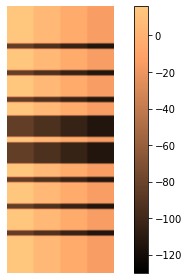

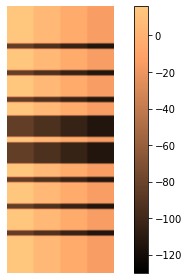

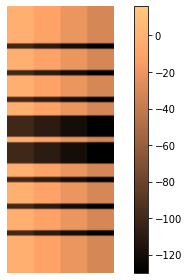

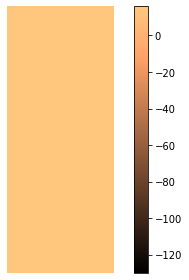

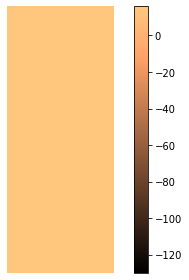

In [16]:
plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"gammaActionGridworld_recovered_1",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1),"gammaActionGridworld_recovered_2",limit_max,limit_min,color="copper")
plot_reward(np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"gammaActionGridworld_true",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1) - np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"gammaActionGridworld_difference_1",limit_max,limit_min,color="copper")
plot_reward(np.repeat(reward_recovered_2.reshape(n_states,n_actions),10,axis=1) - np.repeat(true_reward.reshape(n_states,n_actions),10,axis=1),"gammaActionGridworld_difference_2",limit_max,limit_min,color="copper")

# Windy Grid

100
100
100
1.5493982402909693e-13


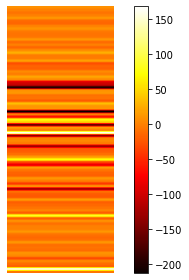

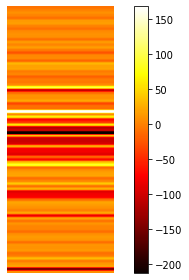

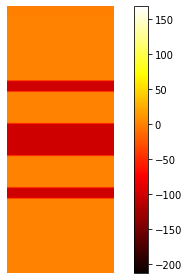

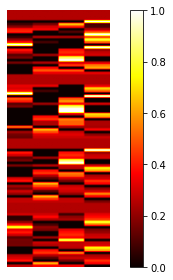

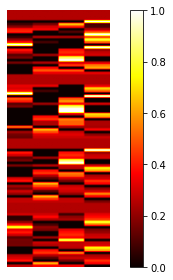

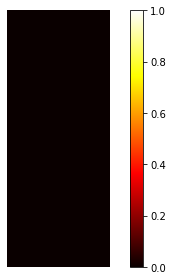

In [10]:
#Different discounts
mode=2
noise=0.0
discount_1=0.2
discount_2=0.7
discount_3=0.9
wind_prob = [0.7,0.1,0.1,0.1]
dim=5
n_states=dim**2*4
n_actions=4
env_1 = WindyGrid(mode, dim,prop=noise, gamma=discount_1,wind_prob=wind_prob)
env_2 = WindyGrid(mode, dim,prop=noise, gamma=discount_2,wind_prob=wind_prob)
env_3 = WindyGrid(mode, dim,prop=noise, gamma=discount_3,wind_prob=wind_prob)

T_1 = env_1.T.transpose(1,0,2)
T_2 = env_2.T.transpose(1,0,2)
T_3 = env_3.T.transpose(1,0,2)


identity = np.array([np.eye(n_states) for a in range(n_actions)]).transpose(1,0,2)
matrix_1 = (identity - discount_1*T_1).reshape(n_states*n_actions, -1) 
matrix_2 = (identity - discount_2*T_2).reshape(n_states*n_actions, -1)
matrix_3 = (identity - discount_3*T_3).reshape(n_states*n_actions, -1)

zer = np.zeros_like(matrix_1)
#print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
matrix = np.hstack([matrix_1, - matrix_2])
matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])

rank_A = np.linalg.matrix_rank(matrix)
rank_B = np.linalg.matrix_rank(matrix_B)

ranks = np.array([rank_A, rank_B])

solver_1 = MDPsolver(env_1)
solver_2 = MDPsolver(env_2)
solver_3 = MDPsolver(env_3)


expert_1 = solver_1.soft_value_iteration() 
expert_2 = solver_2.soft_value_iteration() 
expert_3 = solver_3.soft_value_iteration()

b = np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_2.reshape(n_states*n_actions, -1))

v = np.linalg.solve(matrix.T@matrix,matrix.T@b)
v_1 = v[:n_states]
v_2 = v[n_states:]
reward_recovered_1 = np.log(expert_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
reward_recovered_2 = np.log(expert_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
limit_max = max(np.max(reward_recovered_1), np.max(reward_recovered_2), np.max(env_3.r))
limit_min = min(np.min(reward_recovered_1), np.min(reward_recovered_2), np.min(env_3.r))
plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/gammaWindyGridworld_recovered_1"+str(seed), limit_max,limit_min)
plot_reward(np.repeat(env_3.r - reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/gammaWindyGridworld_difference"+str(seed),limit_max,limit_min)
plot_reward(np.repeat(env_3.r,10,axis=1),"figs/gammaWindyGridworld_true"+str(seed),limit_max,limit_min)

copy_env_3 = copy.deepcopy(env_3)
copy_env_3.r = reward_recovered_2.reshape(n_states,n_actions)
recovered_solver_3 = MDPsolver(copy_env_3)

recovered_expert_3 = recovered_solver_3.soft_value_iteration()

plot_reward(np.repeat(expert_3,10,axis=1),"figs/gammaWindyGridworld_expert"+str(seed),1,0)
plot_reward(np.repeat(recovered_expert_3,10,axis=1),"figs/gammaWindyGridworld_recovered_expert"+str(seed),1,0)
plot_reward(np.repeat(recovered_expert_3 - expert_3,10,axis=1),"figs/gammaWindyGridworld_difference_expert"+str(seed),1,0)

print(np.linalg.norm(expert_3 - recovered_expert_3))

In [11]:
def plot_ranks():
    plt.figure()
    #plt.style.use('seaborn')
    plt.scatter(range(2, len(ranks)+1),- ranks[:-1] + ranks[1:] - n_states, marker="*",c="blue", s=200)
    #plt.plot(n_states*np.ones(4), label="|S|")
    plt.ylabel("Rank difference ", fontsize=20)
    plt.xlabel("Number of experts", fontsize=20)
    plt.xticks([2,3,4,5], fontsize=20)
    plt.yticks([0,10,20,30], fontsize=20)
    plt.savefig("figs/gen_condition"+str(seed)+".pdf")
    plt.figure()
    #plt.style.use('seaborn')
    plt.scatter(np.arange(2, len(ranks)+2), np.arange(2*n_states, (len(ranks)+2)*n_states, n_states) - ranks, marker="*",c="blue", s=200)
    #plt.plot(n_states*np.ones(4), label="|S|")
    plt.ylabel("Degrees of freedom", fontsize=20)
    plt.xlabel("Number of experts", fontsize=20)
    plt.xticks([2,3,4,5], fontsize=20)
    plt.yticks([0,20,40,60], fontsize=20)
    plt.savefig("figs/id_condition"+str(seed)+".pdf")

100
100
100
100
100
100
1.8170302958512434e-11


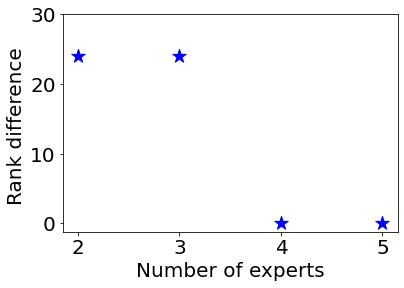

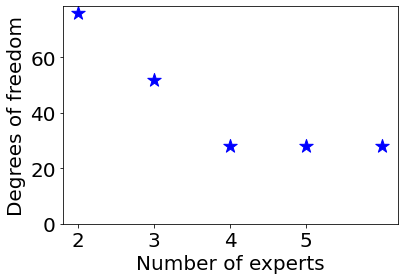

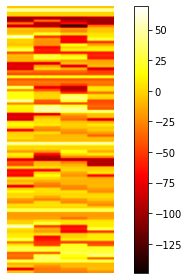

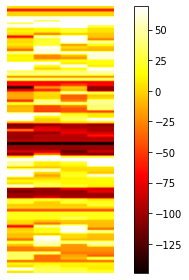

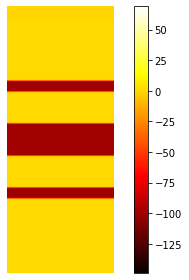

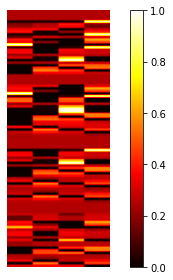

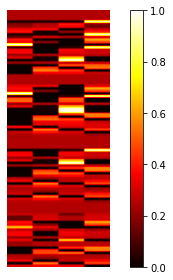

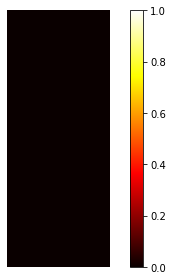

In [12]:
#Random wind prob
for seed in range(1):
    np.random.seed(seed)
    mode=2
    noise_1=0.0
    noise_2=0.0
    noise_3=0.0
    discount_1=0.7
    discount_2=0.7
    discount_3=0.7
    wind_prob_1 = np.random.randn(4) #shape[0.7,0.1,0.1,0.1]
    wind_prob_2 = np.random.randn(4) #shape[0.1,0.7,0.1,0.1]
    wind_prob_3 = np.random.randn(4) #shape[0.1,0.1,0.7,0.1]
    wind_prob_4 = np.random.randn(4) #shape[0.1, 0.1, 0.1, 0.7]
    wind_prob_5 = np.random.randn(4) #shape[0.02, 0.02, 0.94, 0.02]
    wind_prob_6 = np.random.randn(4) #shape[0.02, 0.94, 0.02, 0.02]
    #Normalize
    wind_prob_1 = np.abs(wind_prob_1)/np.sum(np.abs(wind_prob_1)) #shape[0.7,0.1,0.1,0.1]
    wind_prob_2 = np.abs(wind_prob_2)/np.sum(np.abs(wind_prob_2)) #shape[0.1,0.7,0.1,0.1]
    wind_prob_3 = np.abs(wind_prob_3)/np.sum(np.abs(wind_prob_3)) #shape[0.1,0.1,0.7,0.1]
    wind_prob_4 = np.abs(wind_prob_4)/np.sum(np.abs(wind_prob_4)) #shape[0.1, 0.1, 0.1, 0.7]
    wind_prob_5 = np.abs(wind_prob_5)/np.sum(np.abs(wind_prob_5)) #shape[0.02, 0.02, 0.94, 0.02]
    wind_prob_6 = np.abs(wind_prob_6)/np.sum(np.abs(wind_prob_6)) #shape[0.02, 0.94, 0.02, 0.02]
    dim=5
    n_states=dim**2*4
    n_actions=4
    env_1 = WindyGrid(mode, dim,prop=noise_1, gamma=discount_1,wind_prob=wind_prob_1)
    env_2 = WindyGrid(mode, dim,prop=noise_2, gamma=discount_2,wind_prob=wind_prob_2)
    env_3 = WindyGrid(mode, dim,prop=noise_3, gamma=discount_3,wind_prob=wind_prob_3)
    env_4 = WindyGrid(mode, dim,prop=noise_3, gamma=discount_3,wind_prob=wind_prob_4)
    env_5 = WindyGrid(mode, dim,prop=noise_3, gamma=discount_3,wind_prob=wind_prob_5)
    env_6 = WindyGrid(mode, dim,prop=noise_3, gamma=discount_3,wind_prob=wind_prob_6)
    T_1 = env_1.T.transpose(1,0,2)
    T_2 = env_2.T.transpose(1,0,2)
    T_3 = env_3.T.transpose(1,0,2)
    T_4 = env_4.T.transpose(1,0,2)
    T_5 = env_5.T.transpose(1,0,2)
    T_6 = env_6.T.transpose(1,0,2)

    identity = np.array([np.eye(n_states) for a in range(n_actions)]).transpose(1,0,2)
    matrix_1 = (identity - discount_1*T_1).reshape(n_states*n_actions, -1) 
    matrix_2 = (identity - discount_2*T_2).reshape(n_states*n_actions, -1)
    matrix_3 = (identity - discount_3*T_3).reshape(n_states*n_actions, -1)
    matrix_4 = (identity - discount_3*T_4).reshape(n_states*n_actions, -1)
    matrix_5 = (identity - discount_3*T_5).reshape(n_states*n_actions, -1)
    matrix_6 = (identity - discount_3*T_6).reshape(n_states*n_actions, -1)

    zer = np.zeros_like(matrix_1)
    #print(identity.reshape(n_states*n_actions, -1).sum(axis=1))
    matrix = np.hstack([matrix_1, - matrix_2])
    matrix_B = np.vstack([np.hstack([matrix_1, - matrix_2, zer]), np.hstack([matrix_1, zer, -matrix_3])])
    matrix_C = np.vstack([np.hstack([matrix_1, - matrix_2, zer, zer]), np.hstack([matrix_1, zer, -matrix_3, zer]), np.hstack([matrix_1, zer, zer, -matrix_4])])
    matrix_D = np.vstack([np.hstack([matrix_1, - matrix_2, zer, zer,zer]), np.hstack([matrix_1, zer, -matrix_3, zer,zer]), np.hstack([matrix_1, zer, zer, -matrix_4,zer]),  np.hstack([matrix_1, zer, zer,zer, -matrix_5])])
    matrix_E = np.vstack([np.hstack([matrix_1, - matrix_2, zer, zer, zer, zer]), np.hstack([matrix_1, zer, -matrix_3, zer, zer, zer]), np.hstack([matrix_1, zer, zer, -matrix_4,zer,zer]), np.hstack([matrix_1, zer, zer, zer,-matrix_5,zer]), np.hstack([matrix_1, zer, zer, zer,zer,-matrix_6])])

    rank_A = np.linalg.matrix_rank(matrix)
    rank_B = np.linalg.matrix_rank(matrix_B)
    rank_C = np.linalg.matrix_rank(matrix_C)
    rank_D = np.linalg.matrix_rank(matrix_D)
    rank_E = np.linalg.matrix_rank(matrix_E)

    ranks = np.array([rank_A, rank_B, rank_C, rank_D, rank_E])
    plot_ranks()
    solver_1 = MDPsolver(env_1)
    solver_2 = MDPsolver(env_2)
    solver_3 = MDPsolver(env_3)
    solver_4 = MDPsolver(env_4)
    expert_1 = solver_1.soft_value_iteration() 
    expert_2 = solver_2.soft_value_iteration() 
    expert_3 = solver_3.soft_value_iteration() 
    expert_4 = solver_4.soft_value_iteration() 
    
    b = np.vstack([np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_2.reshape(n_states*n_actions, -1)),
               np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_3.reshape(n_states*n_actions, -1)),
               np.log(expert_1.reshape(n_states*n_actions, -1)) - np.log(expert_4.reshape(n_states*n_actions, -1))])
    v = np.linalg.solve(matrix_C.T@matrix_C,matrix_C.T@b)
    v_1 = v[:n_states]
    v_2 = v[n_states:2*n_states]
    reward_recovered_1 = np.log(expert_1.reshape(n_states*n_actions, -1)) - matrix_1@v_1
    reward_recovered_2 = np.log(expert_2.reshape(n_states*n_actions, -1)) - matrix_2@v_2
    limit_max = max(np.max(reward_recovered_1), np.max(reward_recovered_2), np.max(env_5.r))
    limit_min = min(np.min(reward_recovered_1), np.min(reward_recovered_2), np.min(env_5.r))
    plot_reward(np.repeat(reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/WindyGridworld_recovered_1"+str(seed), limit_max,limit_min)
    plot_reward(np.repeat(env_5.r - reward_recovered_1.reshape(n_states,n_actions),10,axis=1),"figs/WindyGridworld_difference"+str(seed),limit_max,limit_min)
    plot_reward(np.repeat(env_5.r,10,axis=1),"figs/WindyGridworld_true"+str(seed),limit_max,limit_min)
    
    copy_env_5 = copy.deepcopy(env_5)
    copy_env_5.r = reward_recovered_2.reshape(n_states,n_actions)
    recovered_solver_5 = MDPsolver(copy_env_5)
    solver_5 = MDPsolver(env_5)
    
    expert_5 = solver_5.soft_value_iteration()
    recovered_expert_5 = recovered_solver_5.soft_value_iteration()
    
    plot_reward(np.repeat(expert_5,10,axis=1),"figs/WindyGridworld_expert"+str(seed),1,0)
    plot_reward(np.repeat(recovered_expert_5,10,axis=1),"figs/WindyGridworld_recovered_expert"+str(seed),1,0)
    plot_reward(np.repeat(recovered_expert_5 - expert_5,10,axis=1),"figs/WindyGridworld_difference_expert"+str(seed),1,0)
    
    print(np.linalg.norm(expert_5 - recovered_expert_5))